In [6]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {'scroll': True,})

%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.abspath("."))

from viewer import ThreeJsViewer

import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
%%html
<style>
body.rise-enabled div.code_cell{
    font-size:60%;
}

body.rise-enabled div.inner_cell>div.promt_container{
    width:10%;
}

body.rise-enabled div.inner_cell>div.text_cell_render.rendered_html {
    font-size: 50%;
}
</style>

# Motion planning and planning scene

## Motion planning

* Collision checking (= path planning)
* Trajectory checking (synchronization, consider speed and acceleration of moving objects) 

<img src="images/path_planning_00.png" width="600" />

# Collision checking

* Intricate positions (spatial assembly)
* Multiple robots working closely

<table>
<tr>
<td><img src="http://www.dfab.arch.ethz.ch/data/ProjectImages/02_Web/M/248/190617_248_robotic_setup_3x2_AX_WM.jpg" style="height: 300px" /></td>
<td><img src="http://www.dfab.arch.ethz.ch/data/ProjectImages/02_Web/M/188/160922_188_BuildupPrototype_MP_01_WM.jpg" style="height: 300px" /></td>
</tr>
</table>



# Trajectory checking

* Synchronisation
* Continuous processes

<table>
<tr>
<td><img src="images/path_planning_04.jpg" style="height: 300px" /></td>
<td><img src="http://www.dfab.arch.ethz.ch/web/images/content/GKR_Infrastructure_7.jpg" style="height: 300px" /></td>
</tr>
</table>


## Path vs. Trajectory

### Path
A sequence of robot configurations in a particular order without regard to the timing between these configurations
(geometric path, obstacle avoidance, shortest path).

### Trajectory
Is concerned about the timing between these configurations (involving accelleration, speed, limits).

In [1]:
"""Example: Joint Trajectory Point and Joint Trajectory
"""

from compas.robots import Joint
from compas_fab.robots import Configuration
from compas_fab.robots import JointTrajectory
from compas_fab.robots import JointTrajectoryPoint

# create configuration
values = [1.571, 0, 0, 0.262, 0, 0]
types = [Joint.REVOLUTE] * 6
c = Configuration(values, types)

# create joint trajectory point
p = JointTrajectoryPoint(values, types)
print(p.accelerations)
print(p.velocities)
print(p.time_from_start)

# create joint trajectory
trj = JointTrajectory([p])


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Duration(0, 0)


## MoveIt!

* ROS’ default motion planning library
* Works with different planners: OMPL (Open Motion Planning Library)
* Collision checking through FCL (Flexible Collision Library)
* Kinematics plugins (default KDL: Kinematics and Dynamics Library)
* Trajectory processing routine

<img src="https://moveit.ros.org/assets/images/moveit2_logo_black.png" width="300">


https://gramaziokohler.github.io/compas_fab/latest/backends/ros.html

docker compose up

## RViz in web browser


http://localhost:8080/vnc.html?resize=scale&autoconnect=true

## RViz in web browser (if you have Docker Toolbox)


http://192.168.99.100:8080/vnc.html?resize=scale&autoconnect=true

<img src="images/moveit_ur5.jpg" width="700" />

<img src="images/moveit_rfl.jpg" width="700" />

<img src="images/moveit_ddad.jpg" width="700" />

## OMPL Planners

PRM, RRT, EST, SBL, KPIECE, SyCLOP, ...

https://ompl.kavrakilab.org/

## Robot class in compas_fab

`robot = Robot(model, artist, semantics, client)`

* model: The robot model, usually created from an URDF structure.
* artist: Instance of the artist used to visualize the robot
* semantics: The semantic model of the robot (planning group, disabled joints)
* client: The backend client to use for communication (planning requests, execution tasks)

In [8]:
import compas_fab
from compas.robots import RobotModel
from compas.robots import LocalPackageMeshLoader
from compas_fab.robots import Robot
from compas_fab.robots import RobotSemantics
from viewer import RobotArtist

urdf_filename = compas_fab.get('universal_robot/ur_description/urdf/ur5.urdf')
srdf_filename = compas_fab.get('universal_robot/ur5_moveit_config/config/ur5.srdf')

model = RobotModel.from_urdf_file(urdf_filename)
loader = LocalPackageMeshLoader(compas_fab.get('universal_robot'), 'ur_description')
model.load_geometry(loader)

semantics = RobotSemantics.from_srdf_file(srdf_filename, model)
artist = RobotArtist(model)

robot = Robot(model, artist=artist, semantics=semantics)
robot


In [9]:
robot.info()

The robot's name is 'ur5'.
The planning groups are: ['manipulator', 'endeffector']
The main planning group is 'manipulator'.
The end-effector's name is 'ee_link'.
The robot has NO tool attached.
The base link's name is 'base_link'
The base_frame is: Frame(Point(0.000, 0.000, 0.000), Vector(1.000, 0.000, 0.000), Vector(-0.000, 1.000, 0.000))
The robot's joints are:
	* 'shoulder_pan_joint' is of type 'revolute' and has limits [6.283, -6.283]
	* 'shoulder_lift_joint' is of type 'revolute' and has limits [6.283, -6.283]
	* 'elbow_joint' is of type 'revolute' and has limits [6.283, -6.283]
	* 'wrist_1_joint' is of type 'revolute' and has limits [6.283, -6.283]
	* 'wrist_2_joint' is of type 'revolute' and has limits [6.283, -6.283]
	* 'wrist_3_joint' is of type 'revolute' and has limits [6.283, -6.283]
The robot's links are:
['base_link', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'ee_link', 'base', 'tool0', 'world']


## Inverse kinematic

In [10]:
from compas.geometry import Frame
from compas_fab.backends import RosClient
from compas_fab.robots import Configuration

frame = Frame([0.3, 0.1, 0.5], [1, 0, 0], [0, 1, 0])
start_configuration = Configuration.from_revolute_values([0] * 6)
group = "manipulator" # or robot.main_group_name

# for those with docker toolbox: check your IP, usually 192.168.99.100
ip = "127.0.0.1"

with RosClient(ip) as client:
    robot.client = client
    config = robot.inverse_kinematics(frame, start_configuration, group)

print(config)

frame_RCF = robot.forward_kinematics(config, backend='model')
frame_WCF = robot.to_world_coords(frame_RCF)
print(frame_WCF)

Configuration((-2.238, -1.153, -2.174, -6.098, 0.667, -6.283), (0, 0, 0, 0, 0, 0))
Frame(Point(0.300, 0.100, 0.500), Vector(1.000, -0.000, -0.000), Vector(0.000, 1.000, 0.000))


In [12]:
from viewer import ThreeJsViewer

robot.update(config)
geo = robot.draw_visual()
viewer = ThreeJsViewer()
viewer.show(geometry=geo)

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(intensity=0.5, position=(0.0, 0.0, 1.…

## 8 (analytic) ik solutions for 6-axis robot

<img src="images/all_ik.jpg" width="800">

## Cartesian path

<div align="middle"><img src="images/cpath.jpg" width="600"/></div>

## Difference between cartesian motion and free-space motion

<img src="images/diff_cm_fsm.svg" width="600" />

In [13]:
from compas.geometry import Frame
from compas_fab.backends import RosClient
from compas_fab.robots import Configuration

frames = []
frames.append(Frame([0.3, 0.1, 0.5], [1, 0, 0], [0, 1, 0]))
frames.append(Frame([0.5, 0.1, 0.6], [1, 0, 0], [0, 1, 0]))
start_configuration = Configuration.from_revolute_values([-0.042, 0.033, -2.174, 5.282, -1.528, 0.000])

ip = "127.0.0.1"
with RosClient(ip) as client:
    robot.client = client

    trajectory = robot.plan_cartesian_motion(frames,
                                             start_configuration,
                                             max_step=0.01,
                                             avoid_collisions=True)

print("Computed cartesian path with %d configurations, " % len(trajectory.points))
print("following %d%% of requested trajectory." % (trajectory.fraction * 100))
print("Executing this path at full speed would take approx. %.3f seconds." % trajectory.time_from_start)

Twisted reactor is already running


Computed cartesian path with 25 configurations, 
following 100% of requested trajectory.
Executing this path at full speed would take approx. 1.001 seconds.


In [14]:
positions = []
velocities = []
accelerations = []
time_from_start = []

for p in trajectory.points:
    positions.append(p.positions)
    velocities.append(p.velocities)
    accelerations.append(p.accelerations)
    time_from_start.append(p.time_from_start.seconds)

Text(0.5, 1.0, 'accelerations')

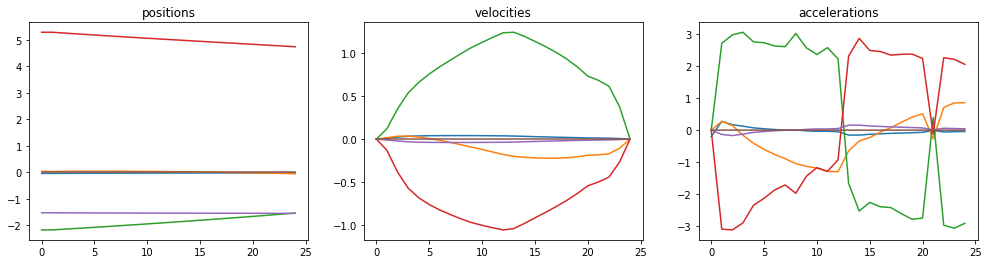

In [26]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [17, 4]
plt.subplot(131)
plt.title('positions')
plt.plot(positions)
plt.subplot(132)
plt.plot(velocities)
plt.title('velocities')
plt.subplot(133)
plt.plot(accelerations)
plt.title('accelerations')

# Free-space motion

The problem of motion planning can be stated as follows. 

Given:
* A start pose of the robot
* A desired goal pose
* A geometric description of the robot
* A geometric description of the world

Find a path that moves the robot gradually from start to goal while never touching any obstacle 

<img src="http://www.willowgarage.com/sites/default/files/blog/200909/path_planning_01.600h.png" />

## Constraints

* __JointConstraint__
        Constrains the value of a joint to be within a certain bound.
* __OrientationConstraint__
        Constrains a link to be within a certain orientation.
* __PositionConstraint__
        Constrains a link to be within a certain bounding volume.

In [15]:
from compas.geometry import Sphere
from compas.geometry import Frame
from compas_fab.robots import BoundingVolume
from compas_fab.robots import JointConstraint
from compas_fab.robots import OrientationConstraint
from compas_fab.robots import PositionConstraint

# Joint Constraint
jc = JointConstraint("joint_0", 1.4, tolerance=0.1, weight=1.)
print(jc)

# Position Constraint
bv = BoundingVolume.from_sphere(Sphere((3,4,5), 0.5))
pc = PositionConstraint('link_0', bv, weight=1.)
print(pc)

# Orientation Constraint
frame = Frame([1, 1, 1], [0.68, 0.68, 0.27], [-0.67, 0.73, -0.15])
oc = OrientationConstraint("link_0", frame.quaternion, tolerances=[0.1, 0.1, 0.1], weight=1.)
print(oc)
                        

JointConstraint('joint_0', 1.4, 0.1, 1.0)
PositionConstraint('link_0', BoundingVolume(2, Sphere(Point(3.000, 4.000, 5.000), 0.5)), 1.0)
OrientationConstraint('link_0', [0.9165245574525535, -0.01934971205862469, -0.15523694045370287, 0.36811658010502973], [0.1, 0.1, 0.1], 1.0)


In [16]:
import math
from compas.geometry import Frame
from compas_fab.robots import Configuration
from compas_fab.backends import RosClient

frame = Frame([0.4, 0.3, 0.4], [0, 1, 0], [0, 0, 1])
tolerance_position = 0.001
tolerance_axes = [math.radians(1)] * 3

start_configuration = Configuration.from_revolute_values([-0.042, 4.295, 0, -3.327, 4.755, 0.])
group = robot.main_group_name

# create goal constraints from frame
goal_constraints = robot.constraints_from_frame(frame,
                                                tolerance_position,
                                                tolerance_axes,
                                                group)

# Other planners 'PRM'
with RosClient() as client:
    robot.client = client
    
    trajectory = robot.plan_motion(goal_constraints,
                                   start_configuration,
                                   group,
                                   planner_id='RRT')

print("Computed kinematic path with %d configurations." % len(trajectory.points))
print("Executing this path at full speed would take approx. %.3f seconds." % trajectory.time_from_start)

Twisted reactor is already running


Computed kinematic path with 39 configurations.
Executing this path at full speed would take approx. 5.169 seconds.


In [17]:
positions = []
velocities = []
accelerations = []
time_from_start = []

for p in trajectory.points:
    positions.append(p.positions)
    velocities.append(p.velocities)
    accelerations.append(p.accelerations)
    time_from_start.append(p.time_from_start.seconds)

Text(0.5, 1.0, 'accelerations')

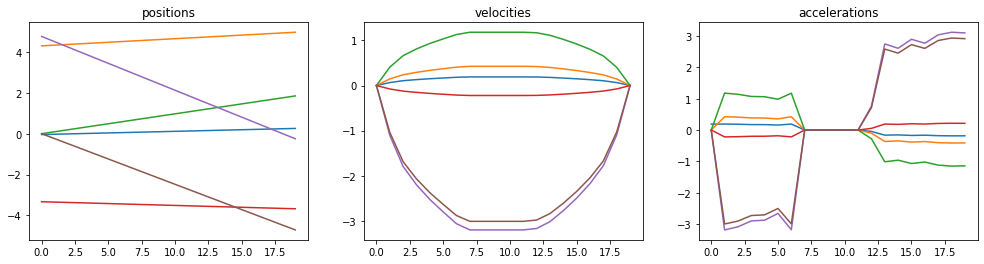

In [31]:
plt.rcParams['figure.figsize'] = [17, 4]
plt.subplot(131)
plt.title('positions')
plt.plot(positions)
plt.subplot(132)
plt.plot(velocities)
plt.title('velocities')
plt.subplot(133)
plt.plot(accelerations)
plt.title('accelerations')

## Planning scene and collision objects

## Collision meshes

In [18]:
"""Example: add a floor to the planning scene
"""
import time

from compas.datastructures import Mesh

import compas_fab
from compas_fab.backends import RosClient
from compas_fab.robots import CollisionMesh
from compas_fab.robots import PlanningScene
from compas_fab.robots.ur5 import Robot

with RosClient() as client:
    robot = Robot(client)

    scene = PlanningScene(robot)
    mesh = Mesh.from_stl(compas_fab.get('planning_scene/floor.stl'))
    cm = CollisionMesh(mesh, 'floor')
    scene.add_collision_mesh(cm)

    # sleep a bit before terminating the client
    time.sleep(1)

Twisted reactor is already running


In [55]:
"""Example: remove the floor from the planning scene
"""
import time

from compas_fab.backends import RosClient
from compas_fab.robots import PlanningScene
from compas_fab.robots.ur5 import Robot

with RosClient() as client:
    robot = Robot(client)
    scene = PlanningScene(robot)
    scene.remove_collision_mesh('floor')

    # sleep a bit before terminating the client
    time.sleep(1)

Twisted reactor is already running


In [56]:
"""Example: add several bricks to the planning scene.
Note: APPEND instead of ADD
"""

import time

from compas.datastructures import Mesh
from compas.geometry import Box

from compas_fab.backends import RosClient
from compas_fab.robots import CollisionMesh
from compas_fab.robots import PlanningScene
from compas_fab.robots.ur5 import Robot

with RosClient() as client:

    robot = Robot(client)
    scene = PlanningScene(robot)

    brick = Box.from_width_height_depth(0.11, 0.07, 0.25)

    for i in range(5):
        mesh = Mesh.from_vertices_and_faces(brick.vertices, brick.faces)
        cm = CollisionMesh(mesh, 'brick')
        cm.frame.point.y += 0.5
        cm.frame.point.z += brick.zsize * i

        scene.append_collision_mesh(cm)

    # sleep a bit before terminating the client
    time.sleep(1)

Twisted reactor is already running


In [57]:
"""Example: remove the floor from the planning scene
"""
import time

from compas_fab.backends import RosClient
from compas_fab.robots import PlanningScene
from compas_fab.robots.ur5 import Robot

with RosClient() as client:
    robot = Robot(client)
    scene = PlanningScene(robot)
    scene.remove_collision_mesh('brick')

    # sleep a bit before terminating the client
    time.sleep(1)

Twisted reactor is already running


## Attach a collision mesh to a robot’s end-effector

In [58]:
import time

from compas.datastructures import Mesh

import compas_fab
from compas_fab.backends import RosClient
from compas_fab.robots import CollisionMesh
from compas_fab.robots import PlanningScene
from compas_fab.robots.ur5 import Robot

with RosClient() as client:

    robot = Robot(client)
    scene = PlanningScene(robot)

    # create collison objects
    mesh = Mesh.from_stl(compas_fab.get('planning_scene/cone.stl'))
    cm = CollisionMesh(mesh, 'tip')

    # attach it to the end-effector
    group = robot.main_group_name
    scene.attach_collision_mesh_to_robot_end_effector(cm, group=group)

    # sleep a bit before terminating the client
    time.sleep(1)

Twisted reactor is already running


## Plan path with attached collision mesh

In [66]:
import math
from compas.geometry import Frame
from compas_fab.backends import RosClient
from compas_fab.robots import Configuration
from compas_fab.robots import AttachedCollisionMesh

frame = Frame([0.4, 0.3, 0.4], [0, 1, 0], [0, 0, 1])
tolerance_position = 0.001
tolerance_axes = [math.radians(1)] * 3

start_configuration = Configuration.from_revolute_values([-0.042, 4.295, 0, -3.327, 4.755, 0.])
group = robot.main_group_name

# create attached collision object
mesh = Mesh.from_stl(compas_fab.get('planning_scene/cone.stl'))
cm = CollisionMesh(mesh, 'tip')
ee_link_name = 'ee_link'
touch_links = ['wrist_3_link', 'ee_link']
acm = AttachedCollisionMesh(cm, ee_link_name, touch_links)

# create goal constraints from frame
goal_constraints = robot.constraints_from_frame(frame,
                                                tolerance_position,
                                                tolerance_axes,
                                                group)

# Other planners 'PRM'
with RosClient() as client:
    robot.client = client    
    trajectory = robot.plan_motion(goal_constraints,
                                   start_configuration,
                                   group,
                                   planner_id='RRT',
                                   attached_collision_meshes=[acm])

print("Computed kinematic path with %d configurations." % len(trajectory.points))
print("Executing this path at full speed would take approx. %.3f seconds." % trajectory.time_from_start)

Twisted reactor is already running


Computed kinematic path with 46 configurations.
Executing this path at full speed would take approx. 5.736 seconds.


## Continue with grasshopper...

https://github.com/compas-dev/compas_fab/blob/master/docs/examples/03_backends_ros/files/robot.ghx
